OSCILADOR ARMÓNICO AMORTIGUADO FORZADO: ¿Cuándo aparece el caos?

In [8]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import scipy as scipy
from math import *
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


VALORES NUMÉRICOS DEL PROBLEMA

Condiciones iniciales

In [2]:
x_0 = 10 # Posición inicial (arb)
v_0 = 0 # Velocidad inicial (arb)

Parámetros del sistema

In [19]:
w_0 = 0.5 # Frecuencia natural x>0
w = 1.5 # constante de amortiguamiento
f_0 = 0.25 # Amplitud de la fuerza por unidad de masa
T = 2*np.pi/w # Periodo fuerza externa

Damping coefficient

In [4]:
damort = 0.005 # paso en el amortiguamiento
amort =  np.array([i*damort for i in range(int(0/damort),int(0.125/damort)+1)]) # Constante de amortiguamiento
tcarac = 1/amort
#print(tcarac)

C:\Users\rodri\AppData\Local\Temp\ipykernel_44028\3510089376.py:3: RuntimeWarning: divide by zero encountered in divide
  tcarac = 1/amort


Medida del tiempo

In [5]:
dt = 0.01 # Paso de tiempo
tf = []
t = []
t0 = 0
for i in range(np.size(amort)):
    tf.append(5/amort[i]+1000)  # Tiempo de medida (se asume que t0 = 0)
    if tf[i] == inf:
        tf[i] = 1000
    t.append(np.linspace(t0,tf[i],int(tf[i]/dt)+1)) # Vector de instantes de tiempo

C:\Users\rodri\AppData\Local\Temp\ipykernel_44028\467882513.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  tf.append(5/amort[i]+1000)  # Tiempo de medida (se asume que t0 = 0)


Frencuencia angular natural para x<0

In [6]:
dW_0 = 0.1 # paso en la frecuencia natural para x<0
W_0 =  np.array([w_0+i*dW_0 for i in range(int((15*w_0)/dW_0)+1)]) # Frecuencia natural para x<0
print(W_0)
#W_0 = np.array([2.5])

[0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2.  2.1 2.2
 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5 3.6 3.7 3.8 3.9 4.
 4.1 4.2 4.3 4.4 4.5 4.6 4.7 4.8 4.9 5.  5.1 5.2 5.3 5.4 5.5 5.6 5.7 5.8
 5.9 6.  6.1 6.2 6.3 6.4 6.5 6.6 6.7 6.8 6.9 7.  7.1 7.2 7.3 7.4 7.5 7.6
 7.7 7.8 7.9 8. ]


DEFINIMOS UNA FRECUENCIA NATURAL DEL OSCILADOR QUE DEPENDE DE LA POSICIÓN

In [7]:
def W(x,W_0): # frecuecia angular
    return W_0 - (W_0-w_0)*np.heaviside(x,w_0)

ECUACIÓN DIFERENCIAL

In [14]:
def EDO(t,y,amort,W_0): 
    x,v = y
    # return [v,-2*amort*v-W(x,W_0)**2*x+f_0*np.cos(w*t)] # Classical eqs.
    return [v-amort*x,-W(x,W_0)**2*x-amort*v+f_0*np.cos(w*t)] # Modified eqs.

CÁLCULO DEL EXPONENTE DE LYAPUNOV

Función que calcula el exponente de Lyapunov para unos parámetros del sistema dados

In [15]:
def Lyapunov_exponent(EDO,t,tf,amort,W_0,eps,x_0,v_0):

    N = int((tf-t0)/dt)+1
    
    z = np.zeros([N,2])
    zp = np.zeros([N,2])
    d = np.zeros(N)
    loglist = np.zeros(N)

    z[0] = [x_0,v_0]
    zp[0] = [x_0+eps/np.sqrt(2),v_0+eps/np.sqrt(2)]
    d[0] = eps
   
    sol = scipy.integrate.solve_ivp(EDO, [0,tf], z[0], method = 'Radau',t_eval = t,args = [amort,W_0])
    pos,vel = sol.y
    solL = scipy.integrate.solve_ivp(EDO, [0,tf], zp[0], method = 'Radau',t_eval = t,args = [amort,W_0])
    posL,velL = solL.y
    
    for i in range(1,N):
        z[i] = [pos[i],vel[i]]
        zp[i] = [posL[i],velL[i]]
        d[i] = np.linalg.norm((z[i]-zp[i]))
        loglist[i] = np.log(d[i]/eps)
    
    lyap = np.mean((loglist/t)[-int(N/5):])
    com = scipy.signal.find_peaks(pos)[0][-100:]-scipy.signal.find_peaks(posL)[0][-100:]
    
    if amort != 0:
        if lyap > 0:
            '''
            if abs(np.mean(com)) < 0.1:
                lyap = -lyap
            else:
            '''
            for i in range(1,N):
                d[i] = np.linalg.norm((z[i]-zp[i-round(T/dt)]))
                loglist[i] = np.log(d[i]/eps)
            lyap = np.mean((loglist/t)[-int(N/5):])
            
        if lyap > 0:
            for i in range(1,N):
                d[i] = np.linalg.norm((z[i]-zp[i-2*round(T/dt)]))
                loglist[i] = np.log(d[i]/eps)
            lyap = np.mean((loglist/t)[-int(N/5):])

        if lyap > 0:
            for i in range(1,N):
                d[i] = np.linalg.norm((z[i]-zp[i-3*round(T/dt)]))
                loglist[i] = np.log(d[i]/eps)
            lyap = np.mean((loglist/t)[-int(N/5):])

        if lyap > 0:
            for i in range(1,N):
                d[i] = np.linalg.norm((z[i]-zp[i-4*round(T/dt)]))
                loglist[i] = np.log(d[i]/eps)
            lyap = np.mean((loglist/t)[-int(N/5):])

        if lyap > 0:
            for i in range(1,N):
                d[i] = np.linalg.norm((z[i]-zp[i-5*round(T/dt)]))
                loglist[i] = np.log(d[i]/eps)
            lyap = np.mean((loglist/t)[-int(N/5):])

        if lyap > 0:
            for i in range(1,N):
                d[i] = np.linalg.norm((z[i]-zp[i-6*round(T/dt)]))
                loglist[i] = np.log(d[i]/eps)
            lyap = np.mean((loglist/t)[-int(N/5):])
    
    return [lyap,np.std((loglist/t)[-int(N/5):])]

Cálculo de resultados

In [20]:
lyap = np.zeros([np.size(W_0),np.size(amort)])
disp = np.zeros([np.size(W_0),np.size(amort)])

eps = 1e-2

for i in tqdm(range(np.size(W_0))):
    for j in range(np.size(amort)):
        lyap[i,j],disp[i,j] = Lyapunov_exponent(EDO,t[j],tf[j],amort[j],W_0[i],eps,x_0,v_0)

  0%|          | 0/76 [00:00<?, ?it/s]C:\Users\rodri\AppData\Local\Temp\ipykernel_44028\1800184984.py:25: RuntimeWarning: invalid value encountered in divide
  lyap = np.mean((loglist/t)[-int(N/5):])
C:\Users\rodri\AppData\Local\Temp\ipykernel_44028\1800184984.py:70: RuntimeWarning: invalid value encountered in divide
  return [lyap,np.std((loglist/t)[-int(N/5):])]
  5%|▌         | 4/76 [06:20<1:50:54, 92.42s/it] C:\Users\rodri\AppData\Local\Temp\ipykernel_44028\1800184984.py:38: RuntimeWarning: invalid value encountered in divide
  lyap = np.mean((loglist/t)[-int(N/5):])
C:\Users\rodri\AppData\Local\Temp\ipykernel_44028\1800184984.py:44: RuntimeWarning: invalid value encountered in divide
  lyap = np.mean((loglist/t)[-int(N/5):])
C:\Users\rodri\AppData\Local\Temp\ipykernel_44028\1800184984.py:50: RuntimeWarning: invalid value encountered in divide
  lyap = np.mean((loglist/t)[-int(N/5):])
C:\Users\rodri\AppData\Local\Temp\ipykernel_44028\1800184984.py:56: RuntimeWarning: invalid value

Almacenamiento de datos

In [23]:
import os
newpath = r'.\explyap' 
if not os.path.exists(newpath):
    os.makedirs(newpath)

for i in range(W_0.size):
    np.savetxt('.\explyap/explyap Ω₀ω₀ = '+str(format(W_0[i]/w_0,'.3f'))+'.txt',lyap[i])

Cargo datos almacenados

In [24]:
lyap_rep = np.zeros([np.size(W_0),np.size(amort)])

for i in range(W_0.size):
    f = open('.\explyap/explyap Ω₀ω₀ = '+str(format(W_0[i]/w_0,'.3f'))+'.txt','r')
    lyap_rep[i:] = f.readlines()
    f.close()

Representación gráfica de resultados

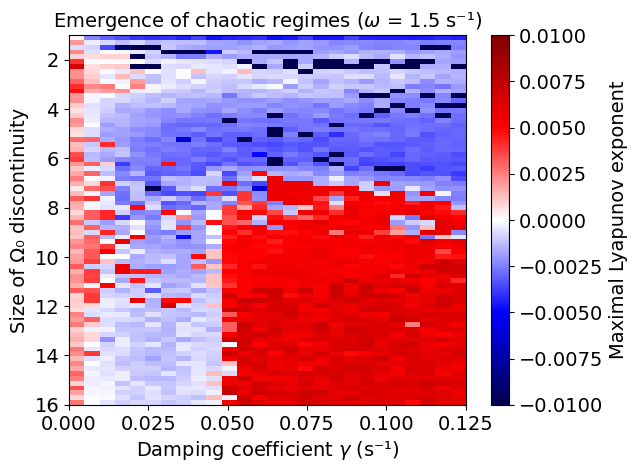

In [32]:
plt.imshow(lyap_rep,cmap = 'seismic',vmin = -0.01, vmax = 0.01, aspect = 'auto', extent = [min(amort),max(amort),max(W_0)/w_0,1])
cbar = plt.colorbar().set_label(label='Maximal Lyapunov exponent',size=14)
plt.title('Emergence of chaotic regimes ($\omega$ = '+str(format(w,'.1f'))+' s⁻¹)',fontsize = 14)
#plt.ylabel('Ω₀(x<0)/Ω₀(x>0)',fontsize = 16)
plt.ylabel('Size of Ω₀ discontinuity',fontsize = 14)
plt.xlabel('Damping coefficient $\gamma$ (s⁻¹)',fontsize = 14)
plt.savefig('fig_reg.png')
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)
plt.show()